## This notebook allows to assess the effect of a given site for a classifcation task.

### 1 : Classify the site 

In [1]:
import os
import csv
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import roc_auc_score

# This notebook presents three methods to evaluate the influence of a parameter on a classfication task : site classification, cross-val on the site value and residualisation. 

## General settings 

In [2]:
# CONFIG
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/all_labels_clean_abcd_new_classes.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"
output_csv  = ""
site = ["site_id_l","demo_sex_v2","interview_age"]
region = "FCMpost-SpC_right"

In [3]:
labels_df = pd.read_csv(labels_path, index_col=0)
print(labels_df["interview_age"].isna().sum())

1


/tmp/ipykernel_5791/992398673.py:1: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  labels_df = pd.read_csv(labels_path, index_col=0)


In [35]:
thresholds  = ["28-32","32-37"]
threshold = thresholds [0]

## Preprocess data 

In [5]:
labels_df = pd.get_dummies(labels_df, columns=['site_id_l'], prefix='', prefix_sep='')

print(labels_df.columns)

    

Index(['demoi_p_select_language___1', 'demo_prim', 'demo_brthdat_v2',
       'demo_ed_v2', 'demo_adopt_agex_v2', 'demo_adopt_agex_v2_bl_dk',
       'demo_sex_v2', 'demo_gender_id_v2', 'demo_race_a_p___10',
       'demo_race_a_p___11',
       ...
       'site13', 'site14', 'site15', 'site16', 'site17', 'site18', 'site19',
       'site20', 'site21', 'site22'],
      dtype='object', length=576)


In [6]:
def define_sex_class_mapping(sex_series):


    unique_sex = sorted(sex_series.unique())

    print("unique sites :", unique_sex)

    mapping = {1.0: 0, 2.0:1, 3.0 : 1}
    
    def encoder_fn(site):
        return mapping[site]
    
    return mapping, encoder_fn


mapping, encode_site = define_sex_class_mapping(labels_df['demo_sex_v2'])
labels_df['sex'] = labels_df['demo_sex_v2'].apply(encode_site)

print(labels_df["sex"].value_counts())   

unique sites : [1.0, 2.0, 3.0]
sex
0    5248
1    4737
Name: count, dtype: int64


In [7]:
labels_df ["interview_age"].fillna(115,inplace =True)

def define_scan_age_mapping(scan_ages_series): 


    unique_scan_ages = sorted(scan_ages_series.unique())



    scaler = StandardScaler()
    scan_ages =np.array(scan_ages_series).reshape(-1 ,1)
    scaler.fit(scan_ages)
    print("unique_scan_ages :",unique_scan_ages)

    def encoder_fn(scan_age):
        return scaler.transform(np.array(scan_age).reshape(-1,1))
    
    return scaler, encoder_fn

scaler, encode_scan_age = define_scan_age_mapping(labels_df["interview_age"])

labels_df['scan_age']= labels_df['interview_age'].apply(encode_scan_age)





/tmp/ipykernel_5791/3730715020.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  labels_df ["interview_age"].fillna(115,inplace =True)


unique_scan_ages : [107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0]


In [43]:
def setup_task(region, site): 

    embedding_file = None
    for file in os.listdir(base_path):
        if file.startswith(region) and file.endswith(".csv"):
            embedding_file = file
            break
    if embedding_file is None:
        raise FileNotFoundError(f"No embedding file found for region: {region}")
    
    emb_path = os.path.join(base_path, embedding_file)
    emb_df = pd.read_csv(emb_path)
    emb_df['ID_clean'] = (
        emb_df['ID'].astype(str)
        .str.replace(r"^sub-", "", regex=True)
        .str.replace("_", "", regex=False)
    )

    df = emb_df.merge(
        labels_df,
        left_on='ID_clean', right_on='src_subject_id_clean', how='inner'
    )
    df["scan_age"] = df["scan_age"].apply(lambda x: float(x[0][0]) if isinstance(x, list) else x)

    if site is None :
        df["prematurity_class"]=df["prem_class"].str.replace("_sem","")
        #df= df[df['prematurity_class'].isin([threshold, ">=37"])].copy()
        df['y'] = (df['prematurity_class'] == threshold).astype(int)

    else :     
        df['y'] = df[site].astype(int)
        
    X = df.filter(regex=r'^dim').values
    y = df['y'].values

    return X,y,df




In [29]:
def classify(region, site, n_jobs_inner=-1):
    print(f"Début traitement : region={region}")
    
    X, y, _ = setup_task(region,site)
    print(y.shape, X.shape)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='linear', probability=True, class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        pipe, {'svc__C': [0.01, 0.1, 1, 10]},
        cv=cv, scoring='roc_auc', n_jobs=n_jobs_inner
    )
    grid.fit(X, y)
    best_C = grid.best_params_['svc__C']
    cv_scores = cross_val_score(grid.best_estimator_, X, y,
                                cv=cv, scoring='roc_auc', n_jobs=n_jobs_inner)


    print(f"{region} : AUC {cv_scores.mean():.3f}")

    return {
        'region': region,
        'best_C': best_C,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
    }

In [30]:
classify(region = "STi-STs-STpol_right", site="sex",  n_jobs_inner=-1)

Début traitement : region=STi-STs-STpol_right
(9985,) (9985, 32)


KeyboardInterrupt: 

## Second approach : Folds dedicated

In [36]:
def setup_task_per_site(region, site): 

    embedding_file = None
    for file in os.listdir(base_path):
        if file.startswith(region) and file.endswith(".csv"):
            embedding_file = file
            break
    if embedding_file is None:
        raise FileNotFoundError(f"No embedding file found for region: {region}")
    
    emb_path = os.path.join(base_path, embedding_file)
    emb_df = pd.read_csv(emb_path)
    emb_df['ID_clean'] = (
        emb_df['ID'].astype(str)
        .str.replace(r"^sub-", "", regex=True)
        .str.replace("_", "", regex=False)
    )

    df = emb_df.merge(
        labels_df,
        left_on='ID_clean', right_on='src_subject_id_clean', how='inner'
    )

    df["scan_age"] = df["scan_age"].apply(lambda x: float(x[0][0]) if isinstance(x, list) else x)
    df["prematurity_class"]=df["prem_class"].str.replace("_sem","")
    df = df[df['prematurity_class'].isin([threshold, ">=37"])].copy()
    df['y'] = (df['prematurity_class'] == threshold).astype(int)
    print(df["prem_class"].head())
    print(df["prematurity_class"].head())


    split_data = {}

    if site == "site_id_l":
        site_cols = [f"site{str(k).zfill(2)}" for k in range(1, 22)]
        for col in site_cols :
            subset = df[df[col] == 1]
            X = subset.filter(regex=r'^dim').values
            y = subset['y'].values
            print(y)
            split_data[col] = (X, y)

    else : 
        # Split by unique site values
        site_values = df[site].unique()
        print(f"Unique values for {site}:", site_values)

        split_data = {}
        for val in site_values:
            subset = df[df[site] == val]
            if len(subset) < 10:
                print(f"Skipping {site} = {val} (not enough samples)")
                continue
            X = subset.filter(regex=r'^dim').values
            y = subset['y'].values
            split_data[val] = (X, y)

    return split_data
           



In [37]:
from sklearn.model_selection import KFold
def classify_per_site(region, site, n_jobs_inner=-1):
    split_data = setup_task_per_site(region, site)
    results = {}

    for val, (X, y) in split_data.items():
        unique, counts = np.unique(y, return_counts=True)
        if len(unique) < 2:
            print(f"Skipping {val}: only one class present -> {dict(zip(unique, counts))}")
            continue
        print(f"Training for {site} = {val} (n={len(y)})")
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC(kernel='linear', probability=True, class_weight='balanced'))
        ])
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid = GridSearchCV(
            pipe, {'svc__C': [0.01, 0.1, 1, 10]},
            cv=cv, scoring='roc_auc', n_jobs=n_jobs_inner
        )
        grid.fit(X, y)
        best_C = grid.best_params_['svc__C']
        cv_scores = cross_val_score(grid.best_estimator_, X, y,
                                    cv=cv, scoring='roc_auc', n_jobs=n_jobs_inner)
        results[val] = {
            'auc_mean': cv_scores.mean(),
            'auc_std': cv_scores.std(),
            'best_C': best_C
        }
        print(f"{val} | AUC = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    return results


In [38]:
classify_per_site(region = "STs_right", site="site_id_l",  n_jobs_inner=-1)

0    >=37
1    >=37
2    >=37
3    >=37
4    >=37
Name: prem_class, dtype: object
0    >=37
1    >=37
2    >=37
3    >=37
4    >=37
Name: prematurity_class, dtype: object
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site03 | AUC = nan ± nan
Training for site_id_l = site04 (n=593)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site04 | AUC = nan ± nan
Training for site_id_l = site05 (n=304)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site05 | AUC = nan ± nan
Training for site_id_l = site06 (n=457)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site06 | AUC = nan ± nan
Training for site_id_l = site07 (n=267)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site07 | AUC = nan ± nan
Skipping site08: only one class present -> {0: 228}
Training for site_id_l = site09 (n=361)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site09 | AUC = nan ± nan
Training for site_id_l = site10 (n=543)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  

site10 | AUC = nan ± nan
Training for site_id_l = site11 (n=360)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site11 | AUC = nan ± nan
Training for site_id_l = site12 (n=497)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site12 | AUC = nan ± nan
Training for site_id_l = site13 (n=552)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site13 | AUC = nan ± nan
Training for site_id_l = site14 (n=338)
site14 | AUC = 0.718 ± 0.087
Training for site_id_l = site15 (n=340)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site15 | AUC = nan ± nan
Training for site_id_l = site16 (n=836)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site16 | AUC = nan ± nan
Training for site_id_l = site17 (n=466)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site17 | AUC = nan ± nan
Training for site_id_l = site18 (n=267)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not def

site18 | AUC = nan ± nan
Training for site_id_l = site19 (n=310)
site19 | AUC = 0.754 ± 0.132
Training for site_id_l = site20 (n=422)
site20 | AUC = 0.528 ± 0.132
Training for site_id_l = site21 (n=485)


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not define

site21 | AUC = nan ± nan


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


{'site02': {'auc_mean': 0.5896551724137931,
  'auc_std': 0.1091409422571882,
  'best_C': 0.01},
 'site03': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site04': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site05': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site06': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site07': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site09': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site10': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site11': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site12': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site13': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site14': {'auc_mean': 0.7175524475524476,
  'auc_std': 0.08724408312030145,
  'best_C': 10},
 'site15': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site16': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 'site17': {'auc_mean': nan, 'auc_std': nan, 'best_C': 0.01},
 's

## Third approach residualisation regarding the target

In [12]:
from sklearn.linear_model import LinearRegression

def residualize_features(X_train, C_train, X_test, C_test):
    """
    Régressions linéaires univariées (par colonne) des colonnes de X_train 
    sur C_train, et calcul des résidus pour X_train et X_test.
    
    """
    lr = LinearRegression()
    n_feat = X_train.shape[1]
    R_train = np.zeros_like(X_train)
    R_test  = np.zeros_like(X_test)
    
    # Adjust a regression model for each feature in X_train
    for j in range(n_feat):
        lr.fit(C_train, X_train[:, j])
        r2 = lr.score(C_train, X_train[:, j])
        print(f"Dimension {j} : R2 = {r2:.3f}")
        R_train[:, j] = X_train[:, j] - lr.predict(C_train)
        R_test[:,  j] = X_test[:,  j] - lr.predict(C_test)
    
    return R_train, R_test


In [13]:
from sklearn.linear_model import LinearRegression

def classify_with_residualization(region, target_label, confound_cols, n_jobs_inner=-1):
    # Prepare X, y and confounders
    X_full, y_full, df = setup_task(region, target_label) 

    print(df.columns)

    C_full = df[confound_cols].values              # ex: site one-hot, sex, scan_age
    
    # Manual cross-val to residualize in  each fold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    
    for train_idx, test_idx in cv.split(X_full, y_full):
        print("Processing folds : train_idx:", train_idx, "test_idx:",test_idx)
        X_tr, X_te = X_full[train_idx], X_full[test_idx]
        y_tr, y_te = y_full[train_idx], y_full[test_idx]
        C_tr, C_te = C_full[train_idx],  C_full[test_idx]
        
        # residualize features
        X_tr_res, X_te_res = residualize_features(X_tr, C_tr, X_te, C_te)
        
        # Standardisation
        scaler = StandardScaler().fit(X_tr_res)
        X_tr_res = scaler.transform(X_tr_res)
        X_te_res = scaler.transform(X_te_res)

        pipe = SVC(kernel='linear', class_weight='balanced', probability=True)
        grid = GridSearchCV(
            estimator=pipe,
            param_grid={'C': [0.01, 0.1, 1, 10]},
            cv=5,
            scoring='roc_auc',
            n_jobs=n_jobs_inner
        )
        grid.fit(X_tr_res, y_tr)
        best_model = grid.best_estimator_

        # Eval on test set
        proba = best_model.predict_proba(X_te_res)[:, 1]
        aucs.append(roc_auc_score(y_te, proba))

    # Final results
    mean_auc = np.mean(aucs)
    std_auc  = np.std(aucs)
    print(f"{region} | target={target_label} | AUC résidulé = {mean_auc:.3f} ± {std_auc:.3f}")
    return aucs


In [14]:
#C_cols_site = [f"site{str(k).zfill(2)}" for k in range(1, 23)]
C_cols = ["scan_age"]
print(C_cols)

['scan_age']


In [66]:
aucs = classify_with_residualization(
    region="STs_right",
    target_label=None,
    confound_cols=C_cols
)


Index(['ID', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8',
       'dim9',
       ...
       'site17', 'site18', 'site19', 'site20', 'site21', 'site22', 'sex',
       'scan_age', 'prematurity_class', 'y'],
      dtype='object', length=614)
Processing folds : train_idx: [   3    4    5 ... 8733 8735 8736] test_idx: [   0    1    2 ... 8717 8726 8734]
Dimension 0 : R2 = 0.000
Dimension 1 : R2 = 0.000
Dimension 2 : R2 = 0.000
Dimension 3 : R2 = 0.000
Dimension 4 : R2 = 0.000
Dimension 5 : R2 = 0.001
Dimension 6 : R2 = 0.000
Dimension 7 : R2 = 0.000
Dimension 8 : R2 = 0.000
Dimension 9 : R2 = 0.001
Dimension 10 : R2 = 0.000
Dimension 11 : R2 = 0.000
Dimension 12 : R2 = 0.001
Dimension 13 : R2 = 0.000
Dimension 14 : R2 = 0.000
Dimension 15 : R2 = 0.000
Dimension 16 : R2 = 0.000
Dimension 17 : R2 = 0.000
Dimension 18 : R2 = 0.000
Dimension 19 : R2 = 0.000
Dimension 20 : R2 = 0.000
Dimension 21 : R2 = 0.000
Dimension 22 : R2 = 0.000
Dimension 23 : R2 = 0.000
Dimension 24 : R2

In [39]:
def compute_all_scores(region_list, output_csv="all_scores.csv"):
    records = []

    for region in region_list:
        print(f"Processing region: {region}")

        # # AUC per site
        #res_site = classify_per_site(region=region, site="site_id_l", n_jobs_inner=-1)
        #auc_mean_site = np.mean([v['auc_mean'] for v in res_site.values()])
        #auc_std_site = np.std([v['auc_mean'] for v in res_site.values()])
        

        # AUC per sex
        res_sex = classify_per_site(region=region, site="sex", n_jobs_inner=-1)
        print(res_sex)
        auc_prema_sex0 = res_sex[0]["auc_mean"]
        auc_prema_sex1 = res_sex[1]["auc_mean"]

        # Classification sex
        res_clf_sex = classify(region=region, site="sex", n_jobs_inner=-1)
        print(res_clf_sex)
        auc_clf_sex = res_clf_sex['cv_auc_mean']
        std_clf_sex = res_clf_sex['cv_auc_std']

        # residualisation on sex
        aucs_res_sex = classify_with_residualization(
            region=region,
            target_label=None,
            confound_cols=["sex"]
        )
        auc_res_sex = np.mean(aucs_res_sex)
        std_res_sex = np.std(aucs_res_sex)

        # Residualisation on scan_age
        aucs_res_age = classify_with_residualization(
            region=region,
            target_label=None,
            confound_cols=["scan_age"]
        )
        auc_res_age = np.mean(aucs_res_age)
        std_res_age = np.std(aucs_res_age)

        # Residualisation on site
        site_cols = [f"site{str(k).zfill(2)}" for k in range(1, 23)]
        aucs_res_site = classify_with_residualization(
            region=region,
            target_label=None,
            confound_cols=site_cols
        )
        auc_res_site = np.mean(aucs_res_site)
        std_res_site = np.std(aucs_res_site)

        records.append({
            "region": region,
            "auc_prema_sex0": auc_prema_sex0,
            "auc_prema_sex1": auc_prema_sex1,
            "auc_clf_sex": auc_clf_sex,
            "std_clf_sex": std_clf_sex,
            "auc_res_sex": auc_res_sex,
            "std_res_sex": std_res_sex,
            "auc_res_age": auc_res_age,
            "std_res_age": std_res_age,
            "auc_res_site": auc_res_site,
            "std_res_site": std_res_site,
        })

    df_scores = pd.DataFrame.from_records(records)
    df_scores.to_csv(output_csv, index=False)
    print(f"Saved all scores to {output_csv}")
    return df_scores

regions = ["STs_right", "STi-STs-STpol_right", "FCMpost-SpC_right","FCLp-subsc-FCLa-INSULA_right"]
df_results = compute_all_scores(regions, output_csv="results_AUCs_new_classes_site_ABCD.csv")
print(df_results)


Processing region: STs_right
0    >=37
1    >=37
2    >=37
3    >=37
4    >=37
Name: prem_class, dtype: object
0    >=37
1    >=37
2    >=37
3    >=37
4    >=37
Name: prematurity_class, dtype: object
Unique values for sex: [1 0]
Training for sex = 1 (n=4147)
1 | AUC = 0.795 ± 0.057
Training for sex = 0 (n=4585)
0 | AUC = 0.665 ± 0.043
{1: {'auc_mean': 0.7945733605326308, 'auc_std': 0.05746774897965763, 'best_C': 0.1}, 0: {'auc_mean': 0.6653534406304067, 'auc_std': 0.04260730255540164, 'best_C': 0.01}}
Début traitement : region=STs_right
(9985,) (9985, 32)
STs_right : AUC 0.664
{'region': 'STs_right', 'best_C': 10, 'cv_auc_mean': 0.6643534915485437, 'cv_auc_std': 0.017521028847744338}
Index(['ID', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8',
       'dim9',
       ...
       'site17', 'site18', 'site19', 'site20', 'site21', 'site22', 'sex',
       'scan_age', 'prematurity_class', 'y'],
      dtype='object', length=614)
Processing folds : train_idx: [   0    1    3 ... 

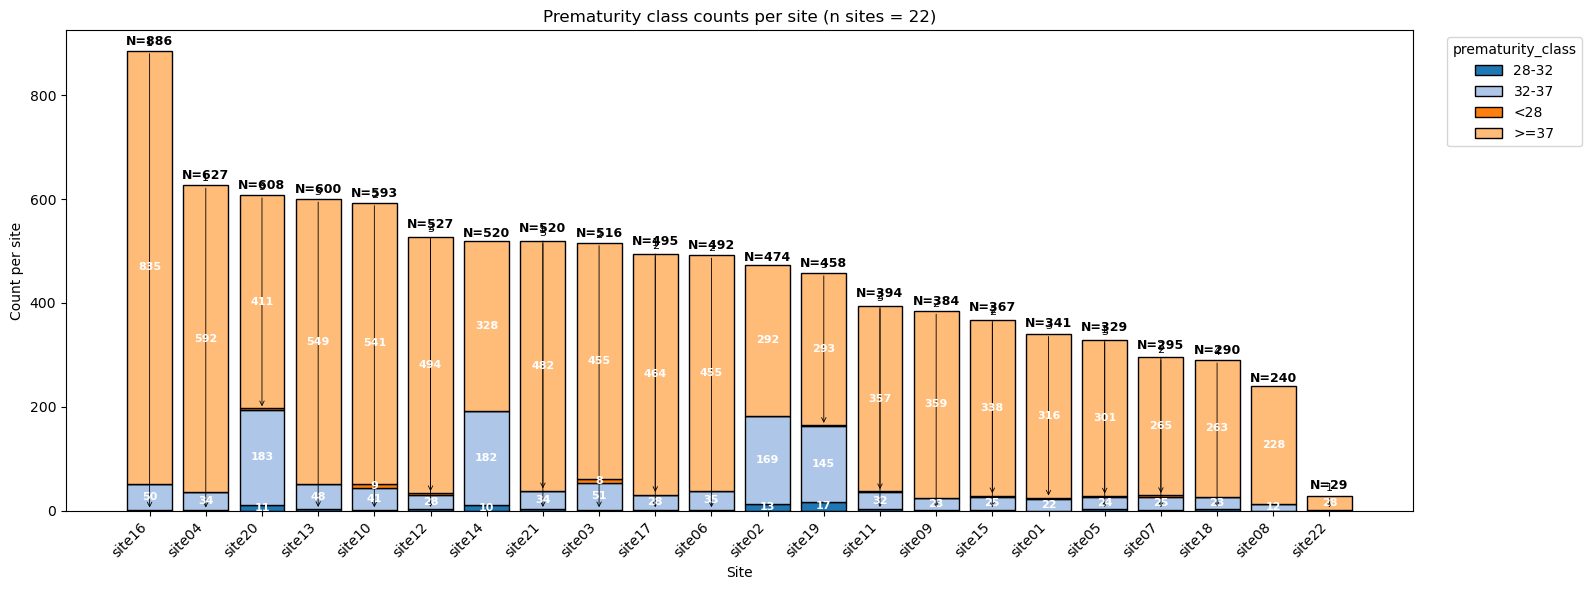


Counts per site (classes + 'total'):


prematurity_class,28-32,32-37,<28,>=37,total
site,,,,,
site16,1,50,0,835,886
site04,1,34,0,592,627
site20,11,183,3,411,608
site13,3,48,0,549,600
site10,2,41,9,541,593
site12,3,28,2,494,527
site14,10,182,0,328,520
site21,3,34,1,482,520
site03,2,51,8,455,516


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def prematurity_counts_by_site_improved(df,
                                        prem_col='prematurity_class',
                                        site_cols=None,
                                        min_n_display=0,
                                        plot=True,
                                        figsize=(16,6),
                                        sort_by='total',
                                        label_threshold=8,
                                        collapse_min_count=None,
                                        collapse_min_prop=None,
                                        external_label_offset=5):

    # detect site columns if not provided ---
    if site_cols is None:
        site_cols = sorted([c for c in df.columns
                            if str(c).startswith('site') and
                               set(df[c].dropna().unique()).issubset({0,1})])
        if len(site_cols) == 0:
            if 'site_id_l' in df.columns:
                site_series = df['site_id_l'].astype(str)
                use_category = True
            elif 'site' in df.columns:
                site_series = df['site'].astype(str)
                use_category = True
            else:
                raise ValueError("No site columns detected. Provide `site_cols` explicitly.")
        else:
            use_category = False
    else:
        use_category = False

    # build raw counts
    if use_category:
        df_counts = df.groupby(site_series)[prem_col].value_counts().unstack(fill_value=0)
    else:
        records_counts = {}
        for col in site_cols:
            subset = df[df[col] == 1]
            counts = subset[prem_col].value_counts()
            records_counts[col] = counts
        df_counts = pd.DataFrame(records_counts).T.fillna(0).astype(int)

    df_counts.index.name = 'site'

    # --- optionally collapse rare classes globally into 'Other' ---
    if collapse_min_count is not None or collapse_min_prop is not None:
        class_totals = df_counts.sum(axis=0)
        total_all = class_totals.sum()
        to_collapse = set()
        if collapse_min_count is not None:
            to_collapse |= set(class_totals[class_totals < collapse_min_count].index)
        if collapse_min_prop is not None:
            to_collapse |= set(class_totals[class_totals / total_all < collapse_min_prop].index)

        if len(to_collapse) > 0:
            # sum collapsed classes into 'Other'
            df_counts['Other'] = df_counts.loc[:, list(to_collapse)].sum(axis=1)
            df_counts.drop(columns=list(to_collapse), inplace=True)
            # ensure deterministic column order (Other at end)
            cols = [c for c in df_counts.columns if c != 'Other'] + ['Other']
            df_counts = df_counts[cols]

    # compute proportions for convenience (not used for plotting counts)
    df_props = df_counts.div(df_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    # add total column
    df_counts['total'] = df_counts.sum(axis=1)
    df_props = df_props.loc[df_counts.index]

    # filter small sites
    if min_n_display > 0:
        keep = df_counts['total'] >= min_n_display
        df_counts = df_counts[keep]
        df_props  = df_props[keep]

    # sorting
    if sort_by == 'total':
        order = df_counts['total'].sort_values(ascending=False).index
    elif sort_by in df_props.columns:
        order = df_props[sort_by].sort_values(ascending=False).index
    else:
        order = df_props.index

    df_counts = df_counts.loc[order]
    df_props = df_props.loc[order]

    # Plot raw counts stacked with smart labels
    if plot:
        class_cols = [c for c in df_counts.columns if c != 'total']
        n_sites = len(df_counts)
        x = np.arange(n_sites)
        fig, ax = plt.subplots(figsize=figsize)

        bottoms = np.zeros(n_sites, dtype=float)
        colors = plt.cm.tab20.colors
        # Draw bars
        for i, cls in enumerate(class_cols):
            heights = df_counts[cls].values
            ax.bar(x, heights, bottom=bottoms, label=str(cls),
                   width=0.8, edgecolor='k', color=colors[i % len(colors)])
            bottoms = bottoms + heights

        # Annotate: internal labels for large segments; external labels for small segments
        # We'll stack external labels above each bar to avoid overlap.
        external_label_counts = np.zeros(n_sites, dtype=int)
        max_total = df_counts['total'].max() if n_sites > 0 else 0
        for si, site in enumerate(df_counts.index):
            cum_bottom = 0
            for cls in class_cols:
                cnt = int(df_counts.at[site, cls])
                if cnt == 0:
                    # advance cumulative bottom and continue
                    cum_bottom += 0
                    continue
                # if segment big enough -> center label
                if cnt >= label_threshold:
                    y = cum_bottom + cnt / 2.0
                    ax.text(si, y, f"{cnt}", ha='center', va='center', fontsize=8, color='white', fontweight='bold', clip_on=False)
                else:
                    # small segment -> external label above the bar, with arrow pointing to the segment center
                    seg_center_y = cum_bottom + cnt / 2.0
                    # compute how many external labels already placed for that site so we can stagger them
                    idx = external_label_counts[si]
                    # vertical offset (in count units)
                    offset = (idx + 1) * external_label_offset
                    text_y = df_counts.at[site, 'total'] + offset
                    ax.annotate(f"{cnt}", xy=(si, seg_center_y), xytext=(si, text_y),
                                ha='center', va='bottom', fontsize=8,
                                arrowprops=dict(arrowstyle='->', lw=0.6, color='black'),
                                clip_on=False)
                    external_label_counts[si] += 1
                # move cumulative bottom by segment height
                cum_bottom += cnt

        # add totals above bars (below last external labels if any)
        for si, site in enumerate(df_counts.index):
            top_y = df_counts.iloc[si].drop('total').sum()
            # place totals above highest external label if any
            extra = external_label_counts[si] * external_label_offset
            ax.text(si, top_y + 1 + extra, f"N={int(df_counts.at[site, 'total'])}", ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.set_xticks(x)
        ax.set_xticklabels(df_counts.index, rotation=45, ha='right')
        ax.set_ylabel('Count per site')
        ax.set_xlabel('Site')
        ax.set_title(f'Prematurity class counts per site (n sites = {n_sites})')
        ax.legend(title=prem_col, bbox_to_anchor=(1.02, 1), loc='upper left')

        # set y limit with margin to include external labels
        ymax = df_counts['total'].max() + (external_label_counts.max()+2) * external_label_offset
        ax.set_ylim(0, ymax * 1.02 + 1)
        plt.tight_layout()
        plt.show()

        print("\nCounts per site (classes + 'total'):")
        display(df_counts.head(200))

    return df_counts, df_props

df_counts, df_props = prematurity_counts_by_site_improved(df, collapse_min_count=10, plot=True)



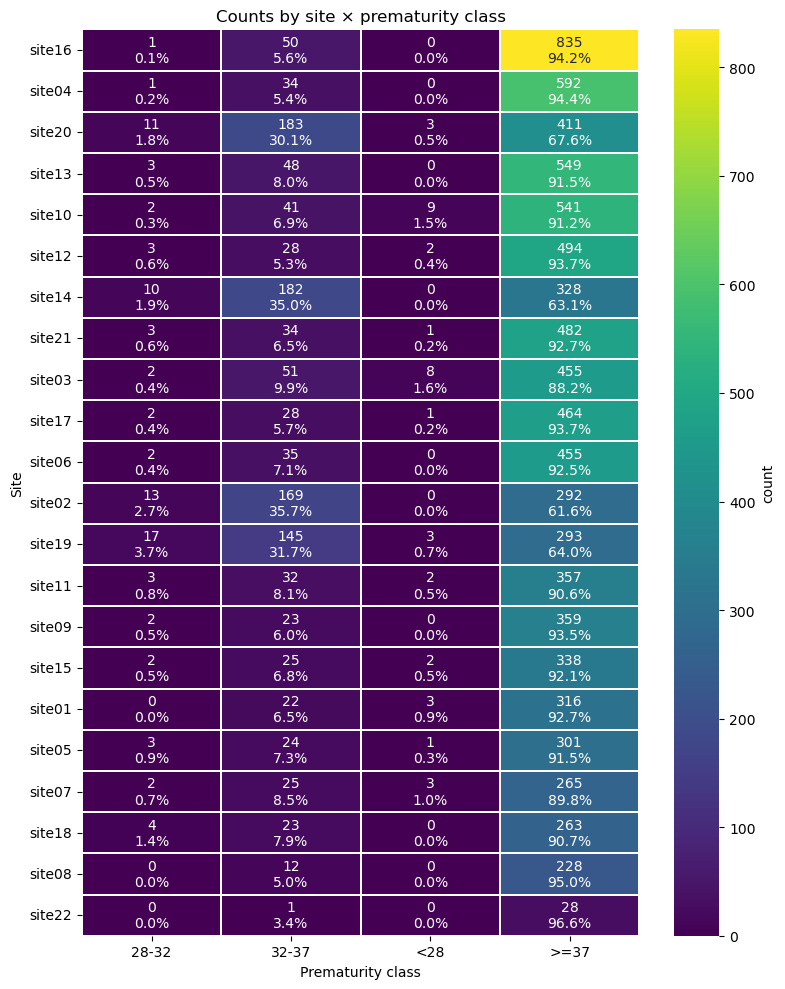

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_site_class_heatmap(df_counts, show='count', cmap='viridis',
                            figsize=(10,8), annot_fontsize=9, vmax=None):
    """
    Plot a heatmap of df_counts (rows=sites, cols=classes).
    show: 'count' (annot counts), 'prop' (annot percents of site), or 'both' (count\npct).
    """
    # remove 'total' if present
    if 'total' in df_counts.columns:
        counts = df_counts.drop(columns='total')
    else:
        counts = df_counts.copy()

    # compute proportions per site
    props = counts.div(counts.sum(axis=1).replace(0,np.nan), axis=0).fillna(0)

    annot = None
    if show == 'count':
        annot = counts.values.astype(int)
    elif show == 'prop':
        annot = (props*100).round(1).astype(str).values
    elif show == 'both':
        annot = np.empty(counts.shape, dtype=object)
        for i in range(counts.shape[0]):
            for j in range(counts.shape[1]):
                annot[i,j] = f"{int(counts.values[i,j])}\n{props.values[i,j]*100:.1f}%"
    else:
        raise ValueError("show must be one of 'count','prop','both'")

    plt.figure(figsize=figsize)
    sns.heatmap(counts, annot=annot, fmt='', cmap=cmap, linewidths=0.3,
                vmax=vmax, cbar_kws={'label':'count'})
    plt.xlabel('Prematurity class')
    plt.ylabel('Site')
    plt.title('Counts by site × prematurity class')
    plt.tight_layout()
    plt.show()

# after make_site_prem_table:
plot_site_class_heatmap(df_counts, show='both', figsize=(8,10))
